# mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls drive

MyDrive


In [3]:
cd /content/drive/MyDrive/Colab Notebooks/recommendation_systems

/content/drive/MyDrive/Colab Notebooks/recommendation_systems


In [4]:
! ls

amazon_review.ipynb	mind_news_recommend_data_process.ipynb
avito.ipynb		mind_news_recommend_distilbert.ipynb
knowledge_distillation	mind_news_recommend_doc2vec.ipynb
livedoor_doc2vec.ipynb	mind_news_recommend_knowledge_distillation.ipynb
mind_dataset


# Install transformer

https://huggingface.co/transformers/installation.html

In [5]:
! pip install transformers
# ! pip install sentencepiece

     |████████████████████████████████| 2.5MB 22.3MB/s 
     |████████████████████████████████| 901kB 53.0MB/s 
     |████████████████████████████████| 3.3MB 40.9MB/s 


# Import modules

In [6]:
import os
import re
import time
import random
from glob import glob
import zipfile
import pickle
from pprint import pprint

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from sklearn import metrics
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from wordcloud import WordCloud

import torch
from torch import nn
import torch.nn.functional as F
import torchtext
from transformers import AutoModel, AutoTokenizer
import torch.optim as optim

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

%load_ext autoreload
%autoreload 2

In [7]:
# train and validate (instead of test) datasets are used here.
data_path_train = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_train/"
data_path_test = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_dev/"
filename_train = data_path_train + "news_click_df.csv"
filename_test = data_path_test + "news_click_df.csv"
select_text_flag = "title"
select_label_flag = "category_flag" # category_flag # click_prob_flag
model_path = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/knowledge_distillation/trained_models/"

## set up environment

In [8]:
cd /content/drive/MyDrive/Colab Notebooks/recommendation_systems

/content/drive/MyDrive/Colab Notebooks/recommendation_systems


In [9]:
ls knowledge_distillation/

data_process.py      model_evaluation.py  __pycache__/
__init__.py          model_kd.py          set_up_environment.py
model_distilbert.py  model_lstm.py        trained_models/
model_doc2vec.py     model_word2vec.py


In [10]:
from knowledge_distillation.set_up_environment import set_random_seed, set_up_gpu

In [11]:
set_random_seed(999)
# device = set_up_gpu()
# print(device)

In [12]:
# Clear memory
# with torch.cuda.device('cuda:0'):
#     torch.cuda.empty_cache()

# Set up GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      

In [13]:
import torch
torch.backends.cudnn.enabled=False

# process data

In [14]:
from knowledge_distillation.data_process import DataProcessing

In [15]:
dp = DataProcessing()
data_df_train = dp.get_data(data_path_train, select_text_flag, select_label_flag)
data_df_test = dp.get_data(data_path_test, select_text_flag, select_label_flag)

0    32812
1       23
Name: click_prob_flag, dtype: int64
1    32020
0      815
Name: category_flag, dtype: int64


,Unnamed: 0,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob,click_prob_flag,category_flag,text,label
0,8,N124534,sports,football_nfl,Should NFL be able to fine players for criticizing officiating?,Several fines came down against NFL players for criticizing officiating this week. It's a very bad look for the league.,https://assets.msn.com/labs/mind/AAJ4lap.html,"[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [7], ""SurfaceForms"": [""NFL""]}]","[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [32], ""SurfaceForms"": [""NFL""]}]",NaN,NaN,0.0,0,1,Should NFL be able to fine players for criticizing officiating?,1
1,18,N107267,sports,football_nfl,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds","Good morning, Eagles fans. Is everybody OK? I know it's been a tough couple days for you all, first with the Eagles' rough 22-14 win over the Chicago Bears and then with the news that the team's most potent deep threat, DeSean Jackson, will likely be out for the season after reinjuring himself during the four snaps he played on Sunday. But hey, it's the bye week. So if you want to use this ...",https://assets.msn.com/labs/mind/AAJWD4e.html,"[{""Label"": ""Philadelphia Eagles"", ""Type"": ""O"", ""WikidataId"": ""Q219714"", ""Confidence"": 0.93, ""OccurrenceOffsets"": [3], ""SurfaceForms"": [""Eagles""]}]","[{""Label"": ""Philadelphia Eagles"", ""Type"": ""O"", ""WikidataId"": ""Q219714"", ""Confidence"": 0.93, ""OccurrenceOffsets"": [14, 109], ""SurfaceForms"": [""Eagles"", ""Eagles""]}, {""Label"": ""DeSean Jackson"", ""Type"": ""P"", ""WikidataId"": ""Q984336"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [220], ""SurfaceForms"": [""DeSean Jackson""]}, {""Label"": ""Chicago Bears"", ""Type"": ""O"", ""WikidataId"": ""Q205033"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [142], ""SurfaceForms"": [""Chicago Bears""]}]",NaN,NaN,0.0,0,1,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds",1


0    22252
1        4
Name: click_prob_flag, dtype: int64
1    21579
0      677
Name: category_flag, dtype: int64


,Unnamed: 0,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob,click_prob_flag,category_flag,text,label
0,7,N124534,sports,football_nfl,Should NFL be able to fine players for criticizing officiating?,Several fines came down against NFL players for criticizing officiating this week. It's a very bad look for the league.,https://assets.msn.com/labs/mind/AAJ4lap.html,"[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [7], ""SurfaceForms"": [""NFL""]}]","[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [32], ""SurfaceForms"": [""NFL""]}]",NaN,NaN,0.0,0,1,Should NFL be able to fine players for criticizing officiating?,1
1,18,N117551,sports,football_nfl,"Rye football wins 2019 rendition of The Game, clobbers Harrison","After going into halftime tied, the Garnets regrouped and made a resounding second-half statement in The Game.",https://assets.msn.com/labs/mind/AAIGv0N.html,[],[],NaN,NaN,0.0,0,1,"Rye football wins 2019 rendition of The Game, clobbers Harrison",1


In [16]:
select_col = ["text","label"]
num_classes = len(data_df_train["label"].unique())
print("num_classes", num_classes)

select_data_df_train = dp.select_data(data_df_train, select_col, decrease_fold=1)
select_data_df_test = dp.select_data(data_df_test, select_col, decrease_fold=1)
select_data_df_train.head(2)

num_classes 2
1    32020
0      815
Name: label, dtype: int64
1    21579
0      677
Name: label, dtype: int64


,text,label
0,Should NFL be able to fine players for criticizing officiating?,1
1,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds",1


In [17]:
select_data_df_train, select_data_df_test = dp.clean_data(select_data_df_train, select_data_df_test)

dp.save_data_to_csv(select_data_df_train, data_path_train, select_columns=["text_clean","label"])
dp.save_data_to_csv(select_data_df_test, data_path_test, select_columns=["text_clean","label"])

filename_ /content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_train/news_click_df.csv
1    32020
0      815
Name: label, dtype: int64
filename_ /content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_dev/news_click_df.csv
1    21579
0      677
Name: label, dtype: int64


# generate models

In [18]:
from knowledge_distillation.model_doc2vec import Doc2vecModelling, Doc2vecModelPrediction
from knowledge_distillation.model_distilbert import DistilBERTModelling
from knowledge_distillation.model_word2vec import Word2vecModelling
from knowledge_distillation.model_lstm import LstmModelling
from knowledge_distillation.model_kd import KnowledgeDistillationModelling
from knowledge_distillation.model_evaluation import plot_confusion_matrix_heatmap

In [19]:
# set up parameters
num_epochs = 10
batch_size = 32

In [20]:
kd = KnowledgeDistillationModelling
dv = Doc2vecModelling
db = DistilBERTModelling
lm = LstmModelling
wv = Word2vecModelling

## Doc2vec Model

(32835, 20)
(22256, 20)
(32835,)
(22256,)
20 2
epoch:  0 	 loss:  119.59026897512376
epoch:  1 	 loss:  109.50648673716933
epoch:  2 	 loss:  108.15913234045729
epoch:  3 	 loss:  107.73685698816553
epoch:  4 	 loss:  107.58227557362989
epoch:  5 	 loss:  107.52083626203239
epoch:  6 	 loss:  107.49517304403707
epoch:  7 	 loss:  107.48398037999868
epoch:  8 	 loss:  107.47879348741844
epoch:  9 	 loss:  107.47611634293571
time :  21.646217584609985
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.98      0.99     32835

    accuracy                           0.98     32835
   macro avg       0.50      0.49      0.49     32835
weighted avg       1.00      0.98      0.99     32835

predicted label:  {1}
Accuracy: 0.9751789249276687
Precision: 0.9509739356230836
Recall: 0.9751789249276687
F1 Score: 0.9629243443430406


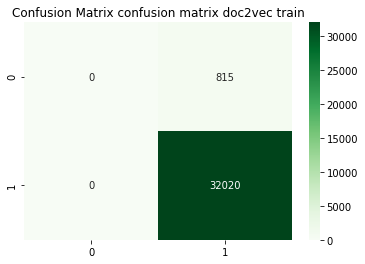

precision_score 0.9751789249276687
roc_auc_score-auc: 0.5
roc_curve-fpr: [0. 1.]
roc_curve-tpr: [0. 1.]


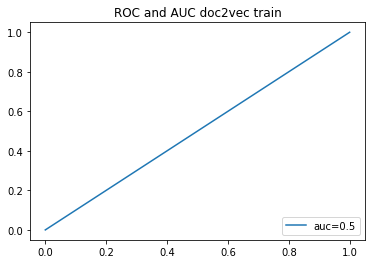

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.97      0.98     22256

    accuracy                           0.97     22256
   macro avg       0.50      0.48      0.49     22256
weighted avg       1.00      0.97      0.98     22256

predicted label:  {1}
Accuracy: 0.9695812365204889
Precision: 0.9400877742126001
Recall: 0.9695812365204889
F1 Score: 0.9546067527261608


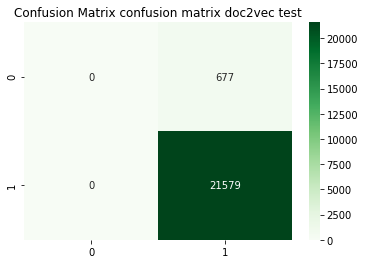

precision_score 0.9695812365204889
roc_auc_score-auc: 0.5
roc_curve-fpr: [0. 1.]
roc_curve-tpr: [0. 1.]


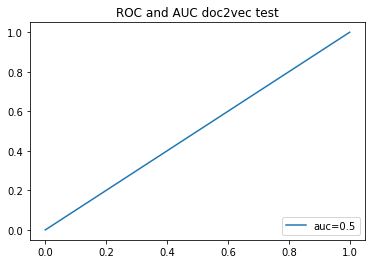

In [21]:
# select data
train_text, train_label, test_text, test_label = dv.select_data(select_data_df_train, select_data_df_test)
# generate doc2vec model
doc2vec_model = dv.generate_doc2vec_model(data_path_train, train_text, 100)
# process train and test data
train_x, train_y, test_x, test_y, train_loader, test_loader = dv.process_data(doc2vec_model, train_text, train_label, test_text, test_label)
# classify data using simple neural network
num_labels = len(set(train_y))
vocab_size = train_x.shape[1]
print(vocab_size, num_labels)
nn_model, train_loader = dv.classfiy_model_neural_network(train_loader, num_labels, vocab_size, num_epochs)

dvmp = Doc2vecModelPrediction
dvmp.predict_texts_nn(nn_model, train_loader, "doc2vec train", num_classes)
dvmp.predict_texts_nn(nn_model, test_loader, "doc2vec test", num_classes)

## DistilBERT Model

In [22]:
filename_train, filename_test

('/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_train/news_click_df.csv',
 '/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_dev/news_click_df.csv')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Size of TEXT vocabulary: 462207
Size of LABEL vocabulary: 3
epoch:  0 	 loss:  39.324145994876744
epoch:  1 	 loss:  20.12685243460146
epoch:  2 	 loss:  10.674601842207267
epoch:  3 	 loss:  3.816153454238645
epoch:  4 	 loss:  1.8533921865647756
epoch:  5 	 loss:  1.0286696216970697
epoch:  6 	 loss:  1.781689621127093
epoch:  7 	 loss:  1.0874847305573496
epoch:  8 	 loss:  1.2647203626205927
epoch:  9 	 loss:  0.8267391190905922
time :  221.09978461265564
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       812
           1       1.00      1.00      1.00     32023

    accuracy                           1.00     32835
   macro avg       1.00      1.00      1.00     32835
weighted avg       1.00      1.00      1.00     32835

predicted label:  {0, 1}
Accuracy: 0.9999086340794884
Precision: 0.9999086426388912
Recall: 0.9999086340794884
F1 Score: 0.9999085519853392


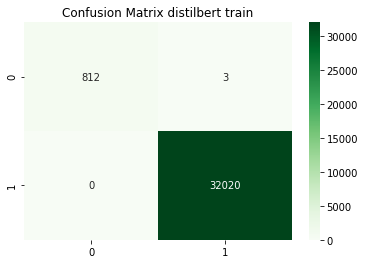

precision_score 0.9999063173344159
roc_auc_score-auc: 0.998159509202454
roc_curve-fpr: [0.         0.00368098 1.        ]
roc_curve-tpr: [0. 1. 1.]


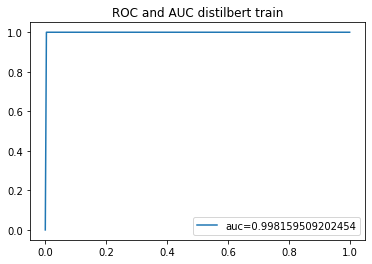

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       675
           1       1.00      1.00      1.00     21581

    accuracy                           1.00     22256
   macro avg       1.00      1.00      1.00     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.9997304097771388
Precision: 0.9997301601712132
Recall: 0.9997304097771388
F1 Score: 0.9997302166223844


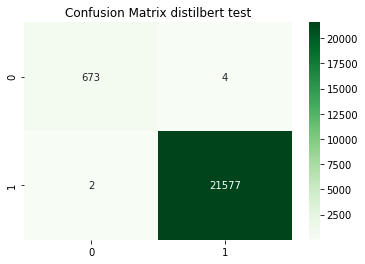

precision_score 0.9998118496624465
roc_auc_score-auc: 0.9969994489007209
roc_curve-fpr: [0.         0.00590842 1.        ]
roc_curve-tpr: [0.         0.99990732 1.        ]


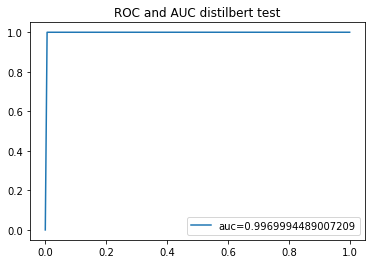

In [23]:
tokenizer  = db.get_tokenizer("distilbert-base-uncased")
distilbert_model = db.generate_model(num_classes)

train_iter_db, test_iter_db = db.process_text(tokenizer, 
                                              filename_train, filename_test, batch_size)

distilbert_model, device = db.train_distilbert(distilbert_model, device, 
                                               train_iter_db, num_classes, num_epochs)

db.predict_distilbert(distilbert_model, device, train_iter_db, "distilbert train", num_classes)
db.predict_distilbert(distilbert_model, device, test_iter_db, "distilbert test", num_classes)

# LSTM Model

Size of TEXT vocabulary: 9554
Size of LABEL vocabulary: 2
[('to', 8724), ('the', 8393), ('in', 6132), ('for', 5027), ('of', 3962), ('on', 3194), ('a', 2961), ('and', 2789), ('with', 2643), ('at', 2346)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f67cb37c990>>, {'<unk>': 0, '<pad>': 1, 'to': 2, 'the': 3, 'in': 4, 'for': 5, 'of': 6, 'on': 7, 'a': 8, 'and': 9, 'with': 10, 'at': 11, 'vs': 12, 'week': 13, 'game': 14, 'football': 15, 'after': 16, 'is': 17, 'from': 18, 'win': 19, 'as': 20, 'state': 21, 'over': 22, 'no': 23, 'out': 24, 'will': 25, 'report': 26, 'season': 27, 'nfl': 28, 'be': 29, 'patriots': 30, 'nt': 31, 'his': 32, 'watch': 33, 'how': 34, 'new': 35, 'against': 36, 'injury': 37, 'has': 38, 'what': 39, 'loss': 40, 'he': 41, 'astros': 42, 'up': 43, 'are': 44, 'this': 45, 'not': 46, 'by': 47, 'team': 48, 'eagles': 49, 'about': 50, 'first': 51, 'have': 52, 'michigan': 53, 'world': 54, 'it': 55, 'back': 56, 'high': 57, 'series': 

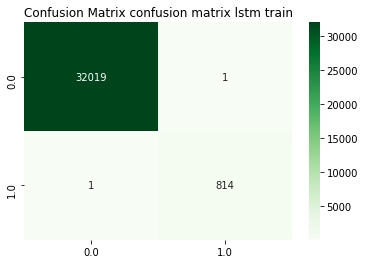

precision_score 0.9975779730907207
roc_auc_score-auc: 0.99937088782701
roc_curve-fpr: [0.00000000e+00 3.12304809e-05 1.00000000e+00]
roc_curve-tpr: [0.         0.99877301 1.        ]


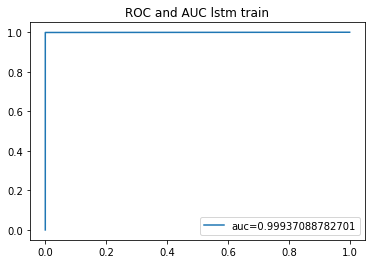

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21583
           1       0.99      0.99      0.99       673

    accuracy                           1.00     22256
   macro avg       0.99      1.00      0.99     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.999370956146657
Precision: 0.9993696958257282
Recall: 0.999370956146657
F1 Score: 0.9993700533778773


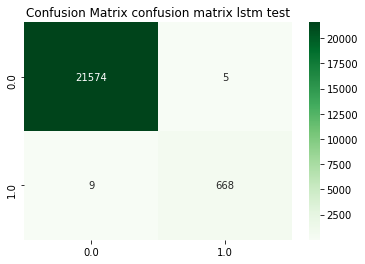

precision_score 0.9797797872582594
roc_auc_score-auc: 0.9932371746890252
roc_curve-fpr: [0.00000000e+00 2.31706752e-04 1.00000000e+00]
roc_curve-tpr: [0.         0.98670606 1.        ]


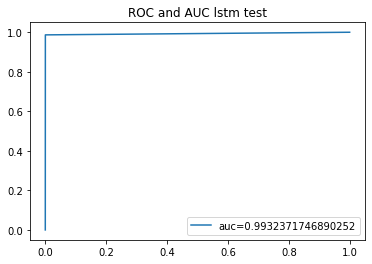

LSTMModel(
  (embedding): Embedding(30000, 128)
  (lstm): LSTM(128, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [24]:
train_iter_lm, test_iter_lm = lm.process_text(filename_train, filename_test, batch_size)
lstm_model = lm.generate_model(num_classes)
lstm_model, device = lm.train(lstm_model, device, train_iter_lm, 
                              num_classes, num_epochs, token_flag="lstm")
lm.predict(lstm_model, device, train_iter_lm, "lstm", "lstm train", num_classes)
lm.predict(lstm_model, device, test_iter_lm, "lstm", "lstm test", num_classes)
lstm_model

## Simple Embedding Model

Size of TEXT vocabulary: 22507
Size of LABEL vocabulary: 2
[('to', 8724), ('the', 8393), ('in', 6132), ('for', 5027), ('of', 3962), ('on', 3194), ('a', 2961), ('and', 2789), ('with', 2643), ('at', 2346)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f683824e9d0>>, {'<unk>': 0, '<pad>': 1, '(sos)': 2, '(eos)': 3, 'to': 4, 'the': 5, 'in': 6, 'for': 7, 'of': 8, 'on': 9, 'a': 10, 'and': 11, 'with': 12, 'at': 13, 'vs': 14, 'week': 15, 'game': 16, 'football': 17, 'after': 18, 'from': 19, 'is': 20, 'win': 21, 'as': 22, 'state': 23, 'over': 24, 'no': 25, 'out': 26, 'will': 27, 'report': 28, 'season': 29, 'nfl': 30, 'be': 31, 'patriots': 32, 'his': 33, 'watch': 34, 'how': 35, 'new': 36, 'against': 37, 'injury': 38, 'loss': 39, 'has': 40, 'astros': 41, 'up': 42, 'this': 43, 'not': 44, 'by': 45, 'what': 46, 'are': 47, 'team': 48, 'eagles': 49, 'about': 50, 'first': 51, 'have': 52, 'michigan': 53, 'world': 54, 'back': 55, 'it': 56, 'high': 57, 'se

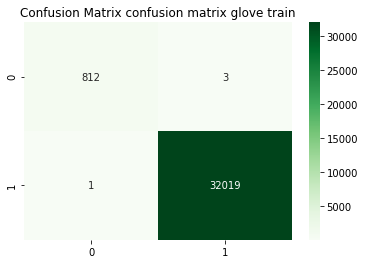

precision_score 0.9999055421605778
roc_auc_score-auc: 0.9981438939619793
roc_curve-fpr: [0.         0.00368098 1.        ]
roc_curve-tpr: [0.         0.99996877 1.        ]


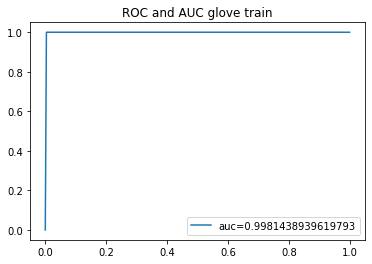

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       670
           1       1.00      1.00      1.00     21586

    accuracy                           1.00     22256
   macro avg       0.99      1.00      1.00     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.9995057512580877
Precision: 0.999504943522463
Recall: 0.9995057512580877
F1 Score: 0.9995045070943648


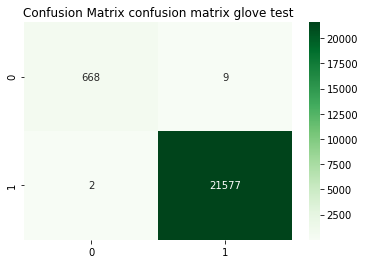

precision_score 0.9995802824461362
roc_auc_score-auc: 0.9933066867146056
roc_curve-fpr: [0.         0.01329394 1.        ]
roc_curve-tpr: [0.         0.99990732 1.        ]


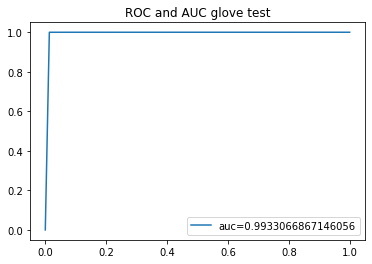

In [25]:
train_iter_mv, test_iter_mv = wv.process_text(filename_train, filename_test, batch_size)
glove_model = wv.generate_model(num_classes)
glove_model, device = wv.train_embedding(glove_model, device, train_iter_mv, num_classes, num_epochs)
wv.predict_embedding(glove_model, device, train_iter_mv, "glove train", num_classes)
wv.predict_embedding(glove_model, device, test_iter_mv, "glove test", num_classes)

# knowledge distillation

In [26]:
token_name = "distilbert"
tokenizer  = db.get_tokenizer("distilbert-base-uncased")
train_iter_kd, test_iter_kd = db.process_text(tokenizer, 
                                              filename_train, filename_test, batch_size)

# train_iter_kd, test_iter_kd = lm.process_text(filename_train, filename_test, batch_size)

Size of TEXT vocabulary: 462207
Size of LABEL vocabulary: 3


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model_name:  distilbert
token_name:  distilbert
epoch:  0 	 loss:  41.431319431227166
epoch:  1 	 loss:  19.983804462579428
epoch:  2 	 loss:  10.859513119514304
epoch:  3 	 loss:  4.2548370659683314
epoch:  4 	 loss:  1.6854247471575263
epoch:  5 	 loss:  0.6634717352968948
epoch:  6 	 loss:  2.462775423921755
epoch:  7 	 loss:  0.5779497681569126
epoch:  8 	 loss:  0.3122551529670119
epoch:  9 	 loss:  0.24458893069596854
time :  625.5626349449158
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       815
           1       1.00      1.00      1.00     32020

    accuracy                           1.00     32835
   macro avg       1.00      1.00      1.00     32835
weighted avg       1.00      1.00      1.00     32835

predicted label:  {0, 1}
Accuracy: 0.9999390893863256
Precision: 0.9999390893863256
Recall: 0.9999390893863256
F1 Score: 0.9999390893863256


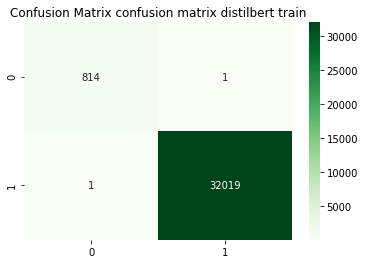

precision_score 0.9999679953202812
roc_auc_score-auc: 0.99937088782701
roc_curve-fpr: [0.         0.00122699 1.        ]
roc_curve-tpr: [0.         0.99996877 1.        ]


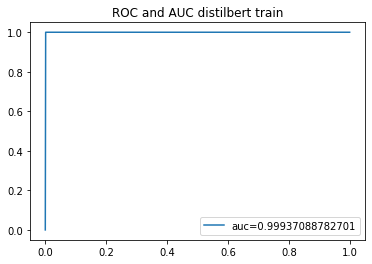

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       679
           1       1.00      1.00      1.00     21577

    accuracy                           1.00     22256
   macro avg       1.00      1.00      1.00     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.9998202731847592
Precision: 0.999820666060074
Recall: 0.9998202731847592
F1 Score: 0.9998204015620735


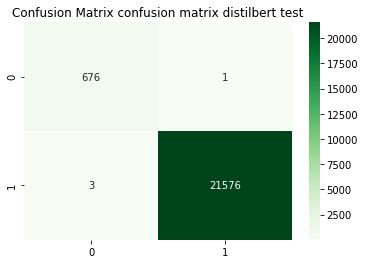

precision_score 0.9999494318576027
roc_auc_score-auc: 0.9991919355371965
roc_curve-fpr: [0.        0.0014771 1.       ]
roc_curve-tpr: [0.         0.99986098 1.        ]


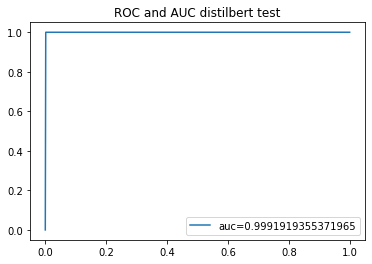

In [27]:
distilbert_model2 = db.generate_model(num_classes)
distilbert_model2, device = kd.train(distilbert_model2, device, 
                                    train_iter_kd, "distilbert", token_name, 
                                    num_classes, num_epochs, model_path)

kd.predict(distilbert_model2, device, train_iter_kd, token_name, "distilbert train", num_classes)
kd.predict(distilbert_model2, device, test_iter_kd, token_name, "distilbert test", num_classes)

LSTMModel(
  (embedding): Embedding(30000, 128)
  (lstm): LSTM(128, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
model_name:  lstm
token_name:  distilbert
epoch:  0 	 loss:  99.78164628485683
epoch:  1 	 loss:  25.368657877872465
epoch:  2 	 loss:  6.947911318289698
epoch:  3 	 loss:  2.8462423576202127
epoch:  4 	 loss:  1.2122496890133334
epoch:  5 	 loss:  0.970859384020514
epoch:  6 	 loss:  2.5686433075461537
epoch:  7 	 loss:  0.45634203608142343
epoch:  8 	 loss:  0.7262173184985841
epoch:  9 	 loss:  0.31499040714402327
time :  1603.6146669387817
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       817
           1       1.00      1.00      1.00     32018

    accuracy                           1.00     32835
   macro avg       1.00      1.00      1.00     32835
weighted avg       1.00      1.00      1.00     32835

predicted label:  {0, 1}
Accuracy: 0.9999390893863256
Precisi

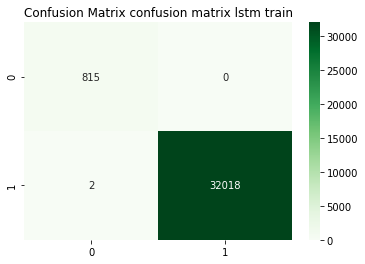

precision_score 0.9999984496517756
roc_auc_score-auc: 0.9999687695190507
roc_curve-fpr: [0. 0. 1.]
roc_curve-tpr: [0.         0.99993754 1.        ]


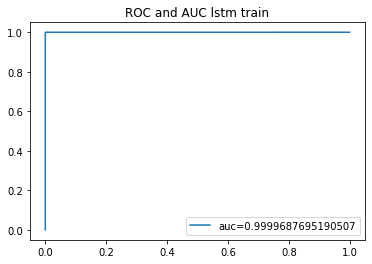

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       675
           1       1.00      1.00      1.00     21581

    accuracy                           1.00     22256
   macro avg       0.99      1.00      1.00     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.9994608195542775
Precision: 0.9994601830474462
Recall: 0.9994608195542775
F1 Score: 0.9994604332447689


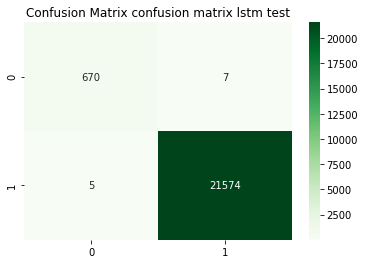

precision_score 0.9996686675331727
roc_auc_score-auc: 0.9947142795634714
roc_curve-fpr: [0.         0.01033973 1.        ]
roc_curve-tpr: [0.         0.99976829 1.        ]


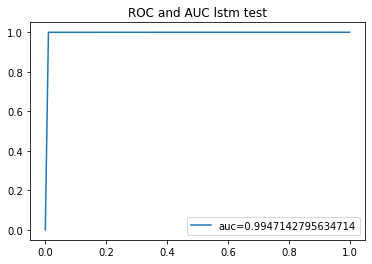

In [28]:
lstm_model2 = lm.generate_model(num_classes)
lstm_model2, device = kd.train(lstm_model2, device, train_iter_kd, 
                                  "lstm", token_name, num_classes, num_epochs, model_path)
kd.predict(lstm_model2, device, train_iter_kd, token_name, "lstm train", num_classes)
kd.predict(lstm_model2, device, test_iter_kd, token_name, "lstm test", num_classes)

2 30000
EmbeddingBagModel(
  (embedding): EmbeddingBag(30000, 128, mode=mean)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
model_name:  glove
token_name:  distilbert
epoch:  0 	 loss:  105.10609928332269
epoch:  1 	 loss:  25.418615865317406
epoch:  2 	 loss:  8.857124024274526
epoch:  3 	 loss:  3.766958424297627
epoch:  4 	 loss:  1.6947024797782433
epoch:  5 	 loss:  0.8765514758310928
epoch:  6 	 loss:  0.5544160577413777
epoch:  7 	 loss:  0.4120842413646386
epoch:  8 	 loss:  0.3201347913432073
epoch:  9 	 loss:  0.29672963641857564
time :  70.6744487285614
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       817
           1       1.00      1.00      1.00     32018

    accuracy                           1.00     32835
   macro avg       1.00      1.00      1.00     32835
weighted avg       1.00      1.00      1.00     32835

predicted label:  {0, 1}
Accuracy: 0.9999390893863256
Precision: 0.999939238494315


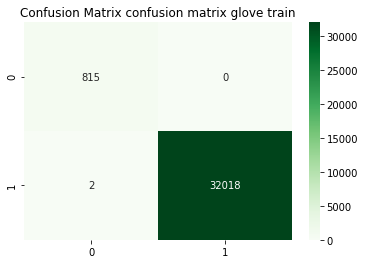

precision_score 0.9999984496517756
roc_auc_score-auc: 0.9999687695190507
roc_curve-fpr: [0. 0. 1.]
roc_curve-tpr: [0.         0.99993754 1.        ]


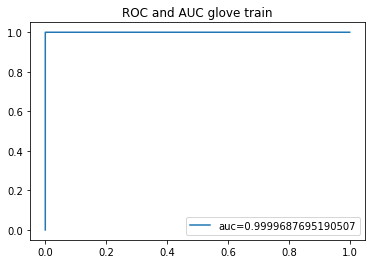

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       676
           1       1.00      1.00      1.00     21580

    accuracy                           1.00     22256
   macro avg       1.00      1.00      1.00     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.9995956146657081
Precision: 0.999595359208135
Recall: 0.9995956146657081
F1 Score: 0.9995954699102836


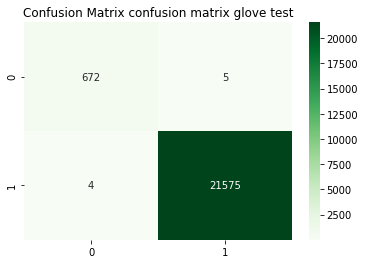

precision_score 0.9997627083472893
roc_auc_score-auc: 0.9962145551131109
roc_curve-fpr: [0.         0.00738552 1.        ]
roc_curve-tpr: [0.         0.99981463 1.        ]


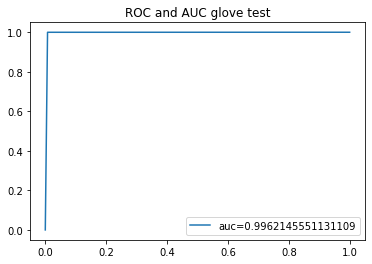

In [29]:
glove_model2 = wv.generate_model(num_classes)

glove_model2, device = kd.train(glove_model2, device, train_iter_kd, 
                                "glove", token_name, num_classes, num_epochs, model_path)
kd.predict(glove_model2, device, train_iter_kd, token_name, "glove train", num_classes)
kd.predict(glove_model2, device, test_iter_kd, token_name, "glove test", num_classes)

In [30]:
# student models
student_model = glove_model2

# teacher models
teachers = [lstm_model2, distilbert_model2]
teachers_name = ["lstm", "distilbert"]

# teachers = [distilbert_model, lstm_model, glove_model]
teacher_models = []
for idx, te_model in enumerate(teachers):
    # print(te_model)
    te_model.load_state_dict(torch.load(model_path + teachers_name[idx] + '.pth'))
    te_model#.to(device)
    # te_model.eval()  # eval mode
    teacher_models.append(te_model)
teacher_models

[LSTMModel(
   (embedding): Embedding(30000, 128)
   (lstm): LSTM(128, 16, num_layers=2, batch_first=True)
   (fc): Linear(in_features=32, out_features=2, bias=True)
 ), DistilBERTClassifierNetwork(
   (distil_bert): DistilBertModel(
     (embeddings): Embeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (transformer): Transformer(
       (layer): ModuleList(
         (0): TransformerBlock(
           (attention): MultiHeadSelfAttention(
             (dropout): Dropout(p=0.1, inplace=False)
             (q_lin): Linear(in_features=768, out_features=768, bias=True)
             (k_lin): Linear(in_features=768, out_features=768, bias=True)
             (v_lin): Linear(in_features=768, out_features=768, bias=True)
             (out_lin): Linear(in_features=768, out_features=768, bias=Tr

epoch:  0 	 loss:  813.9294269382954
epoch:  1 	 loss:  605.5621068328619
epoch:  2 	 loss:  573.3490144833922
epoch:  3 	 loss:  547.3482697382569
epoch:  4 	 loss:  528.6934315860271
epoch:  5 	 loss:  502.33092726022005
epoch:  6 	 loss:  487.4293199107051
epoch:  7 	 loss:  466.83710208535194
epoch:  8 	 loss:  451.5514609515667
epoch:  9 	 loss:  440.2556556388736
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       487
           1       1.00      0.99      0.99     32348

    accuracy                           0.99     32835
   macro avg       0.80      0.99      0.87     32835
weighted avg       0.99      0.99      0.99     32835

predicted label:  {0, 1}
Accuracy: 0.9900106593573931
Precision: 0.9901119485786981
Recall: 0.9900106593573931
F1 Score: 0.9887778527364564


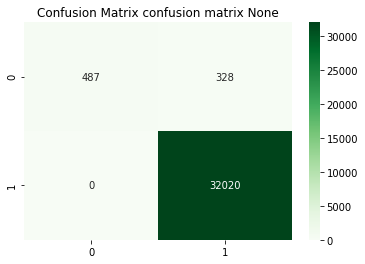

precision_score 0.9898602695684432
roc_auc_score-auc: 0.7987730061349694
roc_curve-fpr: [0.         0.40245399 1.        ]
roc_curve-tpr: [0. 1. 1.]


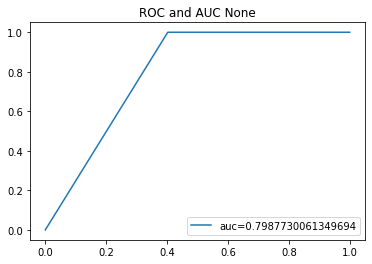

              precision    recall  f1-score   support

           0       0.62      1.00      0.77       423
           1       1.00      0.99      0.99     21833

    accuracy                           0.99     22256
   macro avg       0.81      0.99      0.88     22256
weighted avg       0.99      0.99      0.99     22256

predicted label:  {0, 1}
Accuracy: 0.9884974838245866
Precision: 0.9886037984078009
Recall: 0.9884974838245866
F1 Score: 0.9872031161805213


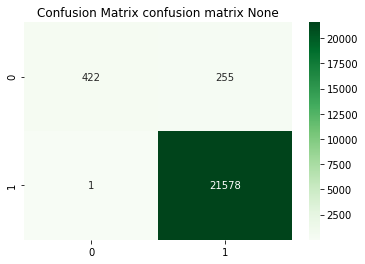

precision_score 0.9883195639733725
roc_auc_score-auc: 0.8116459578329307
roc_curve-fpr: [0.         0.37666174 1.        ]
roc_curve-tpr: [0.         0.99995366 1.        ]


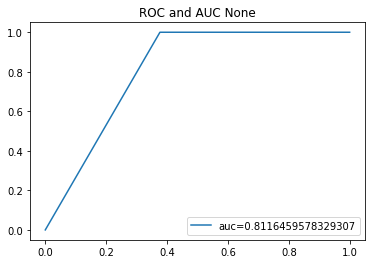

In [31]:
trained_student_model, device = kd.train_multi_teachers_kd(student_model, teacher_models, 
                                                device, 
                                                train_iter_kd, num_epochs)
kd.predict(trained_student_model, device, train_iter_kd, "distilbert", None, num_classes)
kd.predict(trained_student_model, device, test_iter_kd, "distilbert", None, num_classes)

epoch:  0 	 loss:  424.1709022074938
epoch:  1 	 loss:  412.58994238078594
epoch:  2 	 loss:  401.9175530076027
epoch:  3 	 loss:  392.98385758697987
epoch:  4 	 loss:  383.7608246020973
epoch:  5 	 loss:  375.3579293936491
epoch:  6 	 loss:  369.65497392416
epoch:  7 	 loss:  361.8874185681343
epoch:  8 	 loss:  357.87157291173935
epoch:  9 	 loss:  352.1353697963059
epoch:  10 	 loss:  348.46246429905295
epoch:  11 	 loss:  344.84497253224254
epoch:  12 	 loss:  339.89649744331837
epoch:  13 	 loss:  338.6075919866562
epoch:  14 	 loss:  337.3926518559456
epoch:  15 	 loss:  335.2430178001523
epoch:  16 	 loss:  333.2738582715392
epoch:  17 	 loss:  334.7724856212735
epoch:  18 	 loss:  335.84116779081523
epoch:  19 	 loss:  330.4277806468308
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       484
           1       1.00      0.99      0.99     32351

    accuracy                           0.99     32835
   macro avg       0.80    

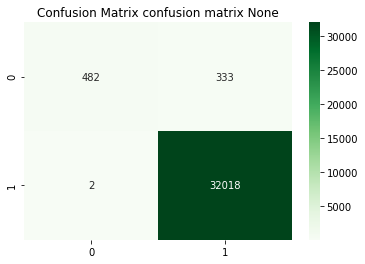

precision_score 0.9897057477105778
roc_auc_score-auc: 0.7956742909914433
roc_curve-fpr: [0.         0.40858896 1.        ]
roc_curve-tpr: [0.         0.99993754 1.        ]


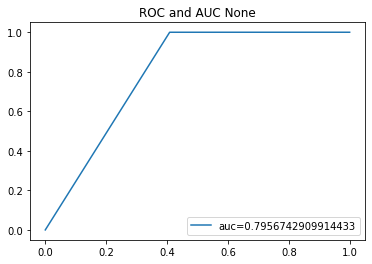

              precision    recall  f1-score   support

           0       0.61      0.99      0.76       419
           1       1.00      0.99      0.99     21837

    accuracy                           0.99     22256
   macro avg       0.81      0.99      0.88     22256
weighted avg       0.99      0.99      0.99     22256

predicted label:  {0, 1}
Accuracy: 0.988138030194105
Precision: 0.9881935842006074
Recall: 0.988138030194105
F1 Score: 0.9867771126247402


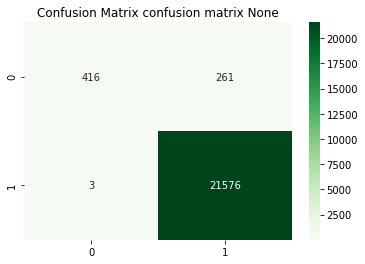

precision_score 0.9880452414672558
roc_auc_score-auc: 0.8071683018592054
roc_curve-fpr: [0.         0.38552437 1.        ]
roc_curve-tpr: [0.         0.99986098 1.        ]


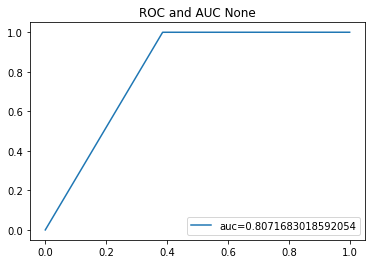

In [33]:
trained_student_model, device = kd.train_multi_teachers_kd(student_model, teacher_models, 
                                                device, 
                                                train_iter_kd, 20)
kd.predict(trained_student_model, device, train_iter_kd, "distilbert", None, num_classes)
kd.predict(trained_student_model, device, test_iter_kd, "distilbert", None, num_classes)

# Unmount and flush google drive

In [32]:
from google.colab import drive
drive.flush_and_unmount()